## Downoload data, import libraries and assign variables

In [1]:
# Dowlnoad dataset from Roboflow 4th version

from roboflow import Roboflow
rf = Roboflow(api_key="jTrkQDoEM9XSpBu2Dm3G")
project = rf.workspace("personal-protective-equipment").project("ppes-kaxsi")
dataset_v_4 = project.version(4).download("yolov8")



loading Roboflow workspace...
loading Roboflow project...
[WARNING] we noticed you are downloading a `yolov8` datasets but you don't have `ultralytics` installed. Roboflow `.deploy` supports only models trained with `ultralytics==8.0.134`, to intall it `pip install ultralytics==8.0.134`.



Extracting Dataset Version Zip to PPEs-4 in yolov8:: 100%|██████████| 23965/23965 [00:30<00:00, 797.58it/s] 


In [2]:
# Import libraries
# Setup paths to labels and images

import os
import yaml
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import statistics
from collections import Counter
from concurrent.futures import ThreadPoolExecutor
import numpy as np
from PIL import Image
from collections import defaultdict

all_labels_paths = ["PPEs-4/train/labels", "PPEs-4/valid/labels"]
all_images_paths = ["PPEs-4/train/images", "PPEs-4/valid/images"]
yaml_file_paths = ["PPEs-4/data.yaml"]


## 1. Class distribution

In [3]:
# Classes essential functions

# Acumulate the classes names count
def get_classes_names_count(yaml_file_path: str, folder_path: str) -> tuple:
    # Read the yaml file and get the classes names
    with open(yaml_file_path, 'r') as stream:
        classes_names = yaml.safe_load(stream)['names']
    # Initialize the classes names count
    classes_names_count = {item: 0 for item in classes_names}
    all_classes_names = []
    
    # Read the label file and increment the corresponding class name
    def read_label_file(file_path: str, classes_names: list, classes_names_count: dict, all_classes_names: list):
        # Security check if file is a file
        if os.path.isfile(file_path):
            file_classes_names = []
            with open(file_path, 'r') as f:
                for line in f:
                    # Get the class name
                    class_name = classes_names[int(line.split()[0])]
                    # Increment the class name count
                    classes_names_count[class_name] += 1
                    file_classes_names.append(class_name)
            all_classes_names.append(file_classes_names)

    # Use multi-threading to read the label file in parallel
    with ThreadPoolExecutor() as executor:
        for filename in os.listdir(folder_path):
            file_path = os.path.join(folder_path, filename)
            # Submit the task to the executor
            future = executor.submit(read_label_file, file_path, classes_names, classes_names_count, all_classes_names)
    

    return classes_names_count, all_classes_names

def merge_dicts(*dict_args : dict) -> dict:
    result = {}
    for dictionary in dict_args:
        # Update the result with the dictionary
        result.update(dictionary)
    return result

# Get the classes names count for each dataset folder path and yaml file path in parallel using multi-threading
classes_names_counts, all_classes_names = zip(*[get_classes_names_count(yaml_file_path, folder_path) for yaml_file_path, folder_path in zip(yaml_file_paths, all_labels_paths)])

# Merge the dictionaries
classes_names_count_all = merge_dicts(*classes_names_counts)

### Class distribution

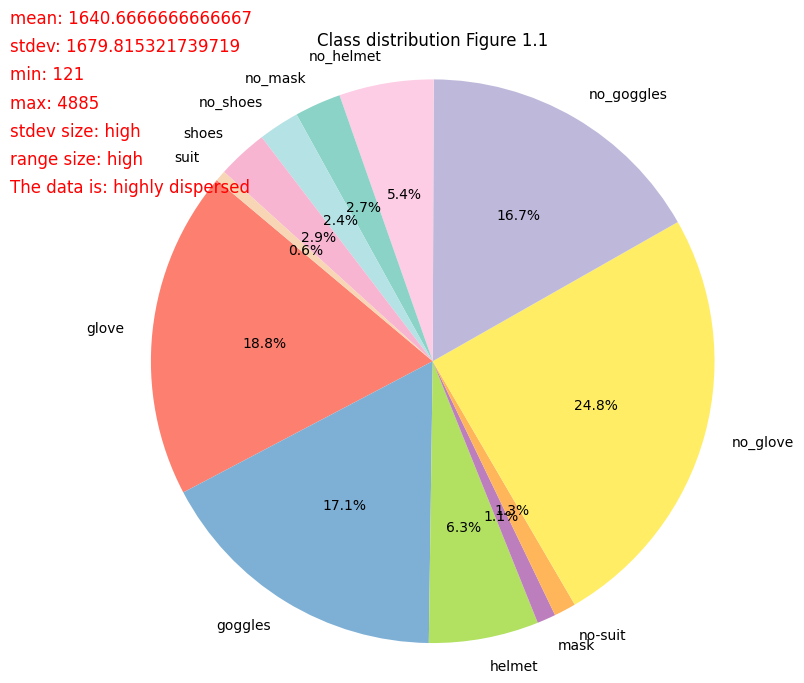

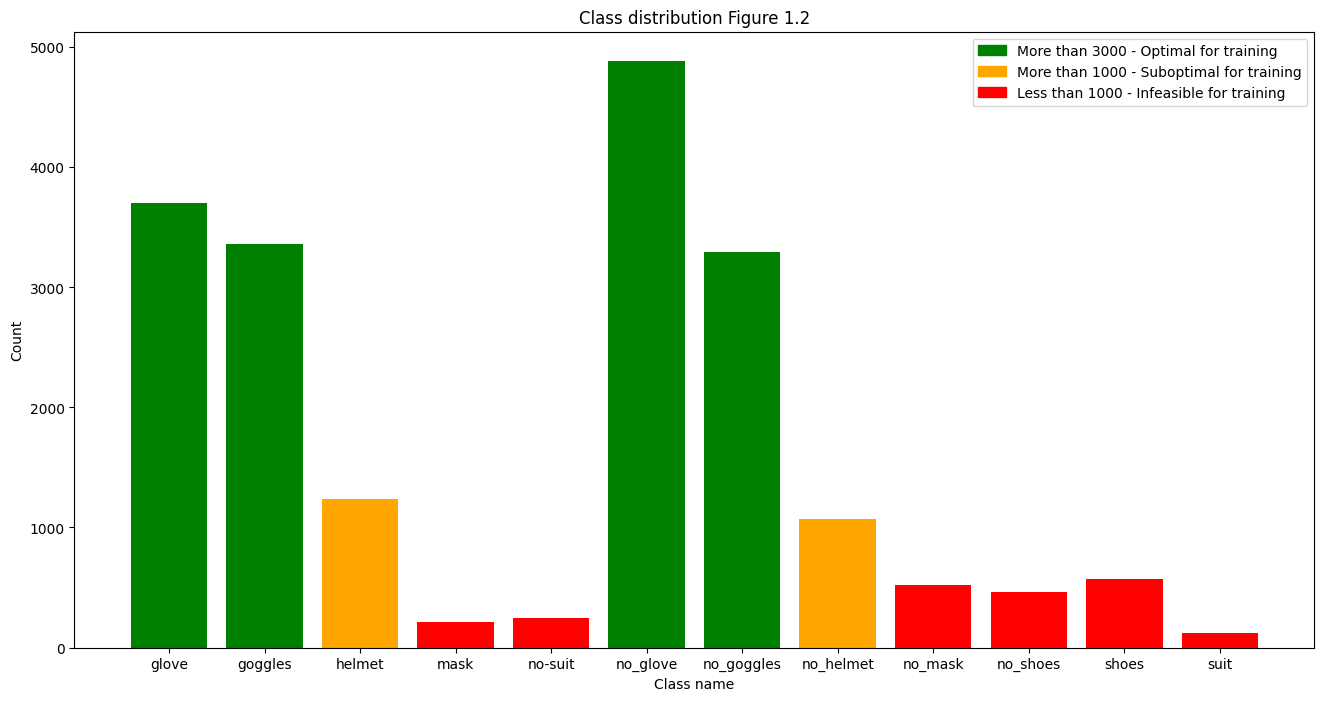

In [20]:
# Analize balance of classes in dataset

# Calculate the standard deviation and coefficient of variation
def stdev_size(data: dict) -> str:
    stdev = statistics.stdev(data)
    mean = statistics.mean(data)
    cv = stdev / mean
    if cv <= 0.33:
        return "low", 0
    elif cv <= 0.66:
        return "medium", 1
    else:
        return "high", 2

# Calculate the range and percentage difference
def range_size(data: dict) -> str:
    range_value = max(data) - min(data)
    percentage_difference = (range_value / max(data)) * 100
    if percentage_difference <= 33:
        return "low", 0
    elif percentage_difference <= 66:
        return "medium", 1
    else:
        return "high", 2

# Calculate the 
def overall_dispersion(data: [int]) -> str:
    #sum the data
    sum = 0
    for i in data:
        sum += i
    if sum <= 0:
        return "no dispersion", 0
    elif sum <= 1:
        return "slightly dispersed", 1
    elif sum <= 2:
        return "moderately dispersed", 2
    else:
        return "highly dispersed", 3
        

# Generate the pie chart with the classes names count and the statistics
def generate_pie_chart(classes_names_count: dict):
    plt.figure(figsize=(8, 8))

    labels = classes_names_count.keys()
    sizes = classes_names_count.values()


    mean = statistics.mean(sizes)
    stdev = statistics.stdev(sizes)
    min_value = min(sizes)
    max_value = max(sizes)
    
    stdev_size_str, stdev_size_value = stdev_size(sizes)
    range_size_str, range_size_value = range_size(sizes)
    overall_dispersion_str, overall_dispersion_value = overall_dispersion([stdev_size_value, range_size_value])

    stats = {
        "mean": mean,
        "stdev": stdev,
        "min": min_value,
        "max": max_value,
        "stdev size": stdev_size_str,
        "range size": range_size_str,
        "The data is": overall_dispersion_str
    }

    colors = ["#fd7f6f", "#7eb0d5", "#b2e061", "#bd7ebe", "#ffb55a", "#ffee65", "#beb9db", "#fdcce5", "#8bd3c7", "#b5e2e5", "#f7b5d1", "#f7d5b5"]



    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
    plt.axis('equal')
    plt.title("Class distribution Figure 1.1")

    for i, (key, value) in enumerate(stats.items()):
        color = 'green' if overall_dispersion_value == '0' else 'yellow' if overall_dispersion_value == '1' else 'orange' if overall_dispersion_value == '2' else 'red'
        plt.text(-1.5, 1.2 - i * 0.1, f"{key}: {value}", fontsize=12, color=color)


    plt.show()
    
def generate_bar_chart(classes_names_count: dict):
    plt.figure(figsize=(16, 8))

    labels = classes_names_count.keys()
    sizes = classes_names_count.values()

    # Generate the colors of the bars
    colors = []
    for size in sizes:
        if size > 3000:
            colors.append('green')
        elif size > 1000:
            colors.append('orange')
        else:
            colors.append('red')

    plt.bar(labels, sizes, color=colors)
    plt.title("Class distribution Figure 1.2")
    plt.xlabel("Class name")
    plt.ylabel("Count")
    
    # Add legend
    green_patch = mpatches.Patch(color='green', label='More than 3000 - Optimal for training')
    orange_patch = mpatches.Patch(color='orange', label='More than 1000 - Suboptimal for training')
    red_patch = mpatches.Patch(color='red', label='Less than 1000 - Infeasible for training')
    
    plt.legend(handles=[green_patch, orange_patch, red_patch])

    plt.show()

# Generate the pie chart
generate_pie_chart(classes_names_count_all)
generate_bar_chart(classes_names_count_all)

## 2 Image size

In [5]:
# Image size analysis essential functions
def get_image_size(folder_path: str) -> list:
    all_heights_widths = []
    
    def get_image_size(file_path : str) -> (int, int):
        with Image.open(file_path) as img:
            return img.size
    
    with ThreadPoolExecutor() as executor:
        for entry in os.scandir(folder_path):
            if entry.is_file():
                file_path = entry.path
                future = executor.submit(get_image_size, file_path)
                all_heights_widths.append(future.result())
    
    return all_heights_widths


all_heights_widths_all = [size for path in all_images_paths for size in get_image_size(path)]

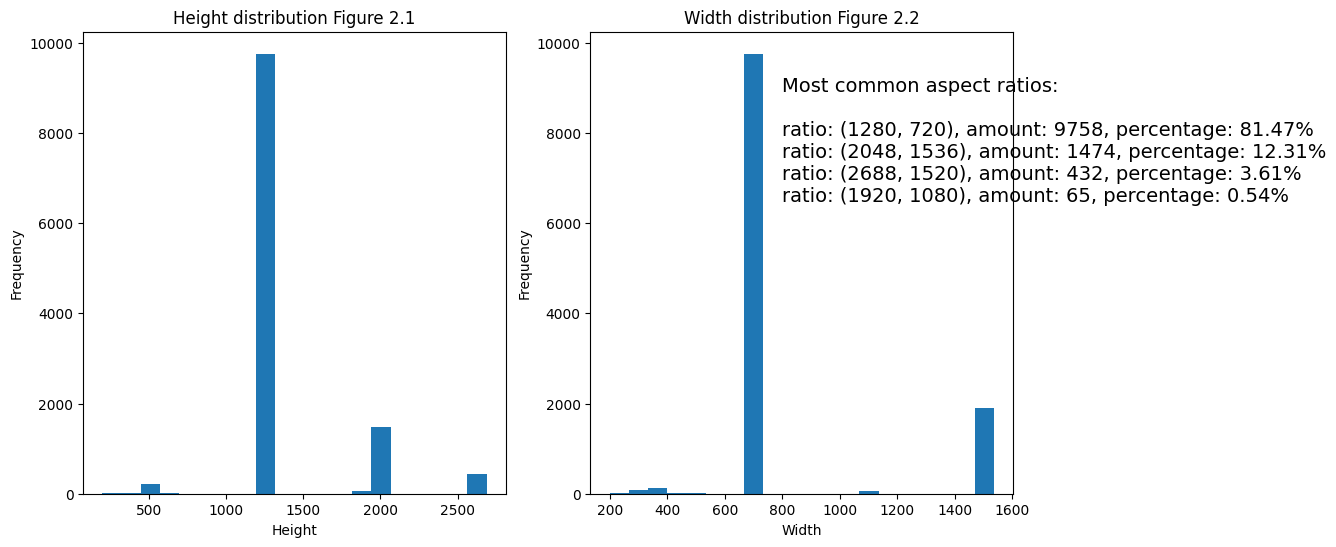

In [29]:
# Analize the size of images



def get_aspect_ratio(all_heights_widths: list) -> list:
    return [height / width for height, width in all_heights_widths]

def generate_histogram(all_heights_widths: list, data: dict = None):
    
    if type(all_heights_widths[0]) is tuple:
        # Get the heights and widths
        heights = [height for height, width in all_heights_widths]
        widths = [width for height, width in all_heights_widths]
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.hist(heights, bins=20)
        plt.title("Height distribution Figure 2.1")
        plt.xlabel("Height")
        plt.ylabel("Frequency")
        plt.subplot(1, 2, 2)
        plt.hist(widths, bins=20)
        plt.title("Width distribution Figure 2.2")
        plt.xlabel("Width")
        plt.ylabel("Frequency")
           
        top_4_most_comon = sorted(data.items(), key=lambda x: x[1], reverse=True)[:4]
        
        top_4_most_comon_one_string = "Most common aspect ratios:\n\n"
        
        for i, (key, value) in enumerate(top_4_most_comon):
            top_4_most_comon_one_string += f"ratio: {key}, amount: {value}, percentage: {round(value / len(all_heights_widths) * 100, 2)}%\n"
        
        plt.text(800, 6000, top_4_most_comon_one_string, fontsize=14)
    
    # Plot the histograms
    plt.show()

def count_all_aspect_ratios_tuples(all_heights_widths: list) -> dict:
    aspect_ratios_tuples = [(height, width) for height, width in all_heights_widths]
    return Counter(aspect_ratios_tuples)





generate_histogram(all_heights_widths_all, count_all_aspect_ratios_tuples(all_heights_widths_all))


## 3 Bounding boxes analysis

In [7]:
# get bounding boxes properties an count essential functions

def get_bounding_boxes_count_and_properties(folders_path: list) -> list:
    all_bounding_boxes_count = []
    all_bounding_boxes_properties = []

    def get_bounding_boxes_count(file_path: str) -> tuple:
        with open(file_path, 'r') as f:
            return file_path, len(f.readlines())

    def get_bounding_boxes_properties(file_path : str) -> list:
        properties = []

        with open(file_path, 'r') as f:
            for line in f:
                class_index, x_center, y_center, width, height = line.split()
                # Add the properties to the list
                properties.extend([int(class_index), float(x_center), float(y_center), float(width), float(height)])
                # If the properties list has 5 elements, add it to the all_bounding_boxes_properties list and clear the properties list
                if len(properties) == 5:
                    all_bounding_boxes_properties.append(properties)
                    properties = []
                
    with ThreadPoolExecutor() as executor:
        for folder_path in folders_path:
            for filename in os.listdir(folder_path):
                file_path = os.path.join(folder_path, filename)
                future = executor.submit(get_bounding_boxes_count, file_path)
                all_bounding_boxes_count.append(future.result())
                future = executor.submit(get_bounding_boxes_properties, file_path)
                properties = future.result()

    return all_bounding_boxes_count, all_bounding_boxes_properties

# Get the bounding boxes count and properties
all_bounding_boxes_count_tuple, all_bounding_boxes_properties = get_bounding_boxes_count_and_properties(all_labels_paths)

# Get the bounding boxes count
glove_boundig_boxes_properties = [properties[1:] for properties in all_bounding_boxes_properties if properties[0] == 0]
googles_boundig_boxes_properties = [properties[1:] for properties in all_bounding_boxes_properties if properties[0] == 1]
no_glove_boundig_boxes_properties = [properties[1:] for properties in all_bounding_boxes_properties if properties[0] == 5]
no_googles_boundig_boxes_properties = [properties[1:] for properties in all_bounding_boxes_properties if properties[0] == 6]

# Get the bounding boxes properties without the class index
all_bounding_boxes_properties_without_class_index = [properties[1:] for properties in all_bounding_boxes_properties]


### Bounding boxes number

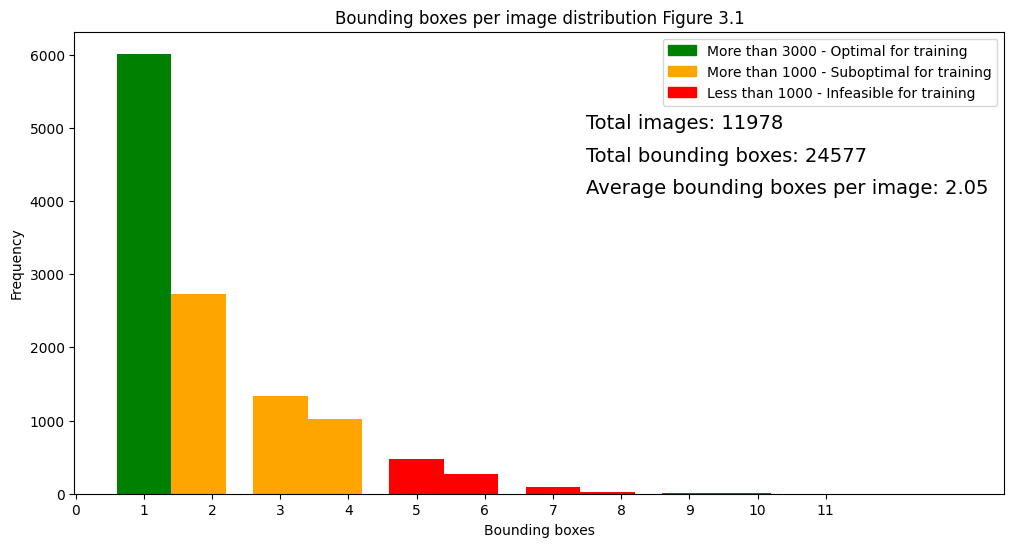

In [40]:
# Analize count of bounding boxes per image

# Get number of all images
def get_image_count(folder_path: str) -> int:
    return len(os.listdir(folder_path))

def generate_histogram(all_bounding_boxes_count: list, all_images_count: int, average_bounding_boxes_per_image: float, total_bounding_boxes: int):
    
    total_bounding_boxes = sum(all_bounding_boxes_count)
    average_bounding_boxes_per_image = total_bounding_boxes / all_images_count
    
    plt.figure(figsize=(12, 6))
    n, bins, patches = plt.hist(all_bounding_boxes_count, bins=30)
    plt.title("Bounding boxes per image distribution Figure 3.1")
    plt.xlabel("Bounding boxes")
    plt.ylabel("Frequency")
    plt.xticks(range(0, 12, 1))
    plt.text(0.55, 0.79, f"Total images: {all_images_count}", transform=plt.gca().transAxes, fontsize=14)
    plt.text(0.55, 0.72, f"Total bounding boxes: {total_bounding_boxes}", transform=plt.gca().transAxes, fontsize=14)
    plt.text(0.55, 0.65, f"Average bounding boxes per image: {average_bounding_boxes_per_image:.2f}", transform=plt.gca().transAxes, fontsize=14)
    
    # Generate the colors of the bars
    colors = []
    for size in n[:-1]:
        if size > 3000:
            colors.append('green')
        elif size > 1000:
            colors.append('orange')
        else:
            colors.append('red')
    
    plt.bar(bins[:-1], n, width=0.8, color=colors)
    
    
    # Add legend
    green_patch = mpatches.Patch(color='green', label='More than 3000 - Optimal for training')
    orange_patch = mpatches.Patch(color='orange', label='More than 1000 - Suboptimal for training')
    red_patch = mpatches.Patch(color='red', label='Less than 1000 - Infeasible for training')
    
    plt.legend(handles=[green_patch, orange_patch, red_patch])
    
    plt.show()

# Get the number of all images
all_images_count = sum([get_image_count(path) for path in all_images_paths])

# Get the bounding boxes count
all_bounding_boxes_count = [count for path, count in all_bounding_boxes_count_tuple]

generate_histogram(all_bounding_boxes_count, all_images_count, sum(all_bounding_boxes_count) / all_images_count, sum(all_bounding_boxes_count))

### Bounding boxes distribution (heatmap)

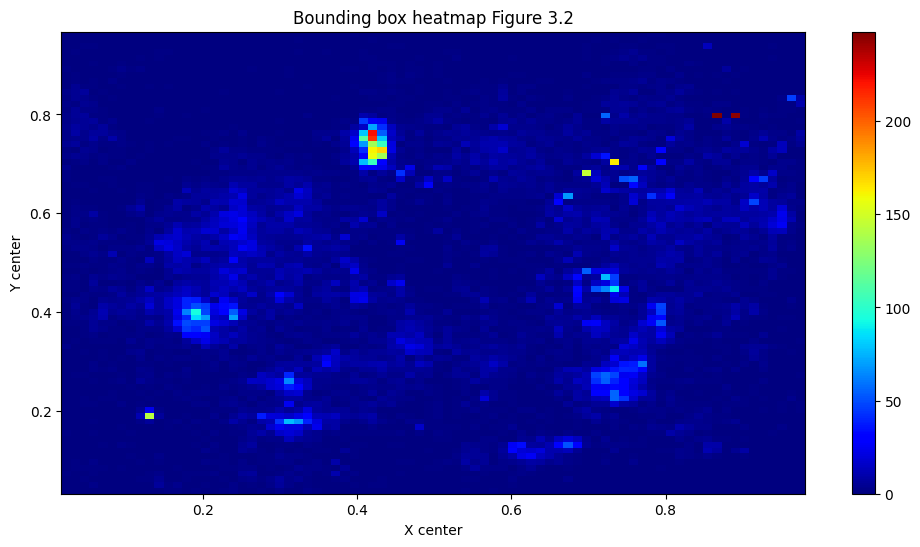

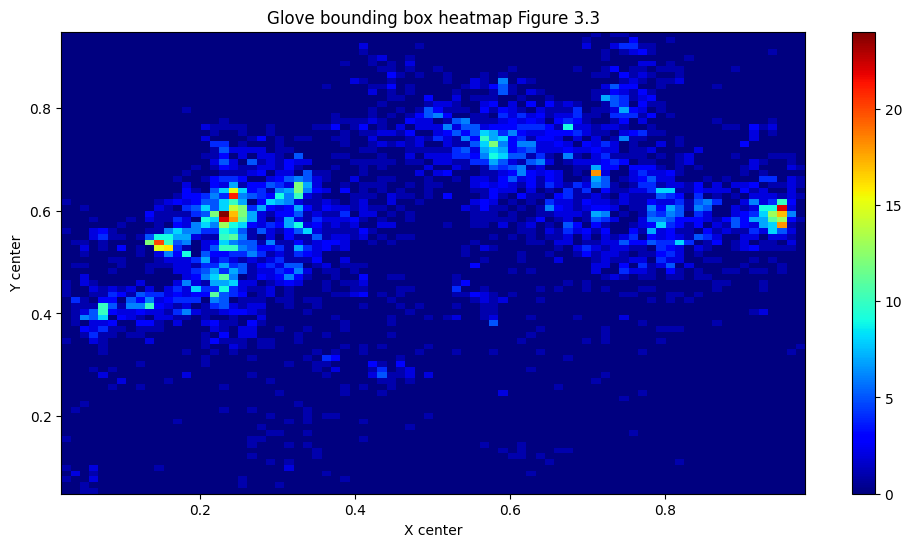

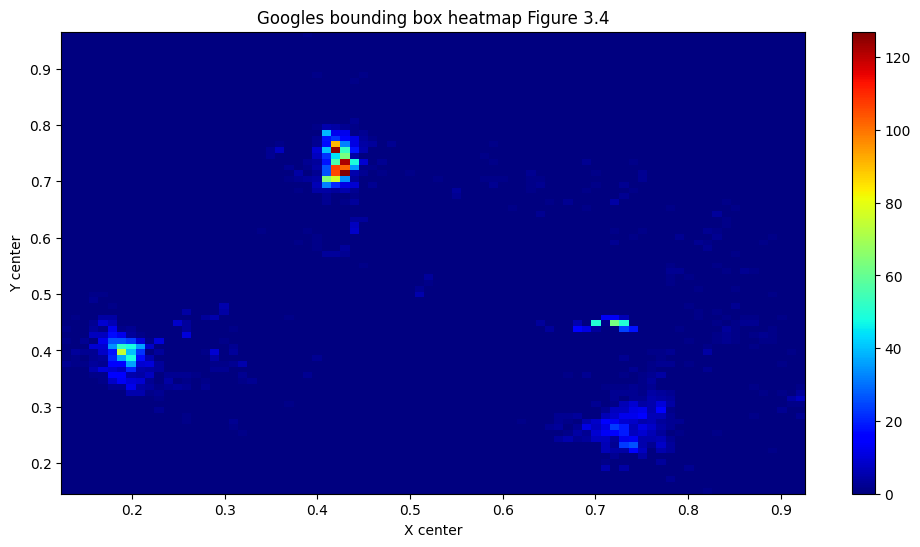

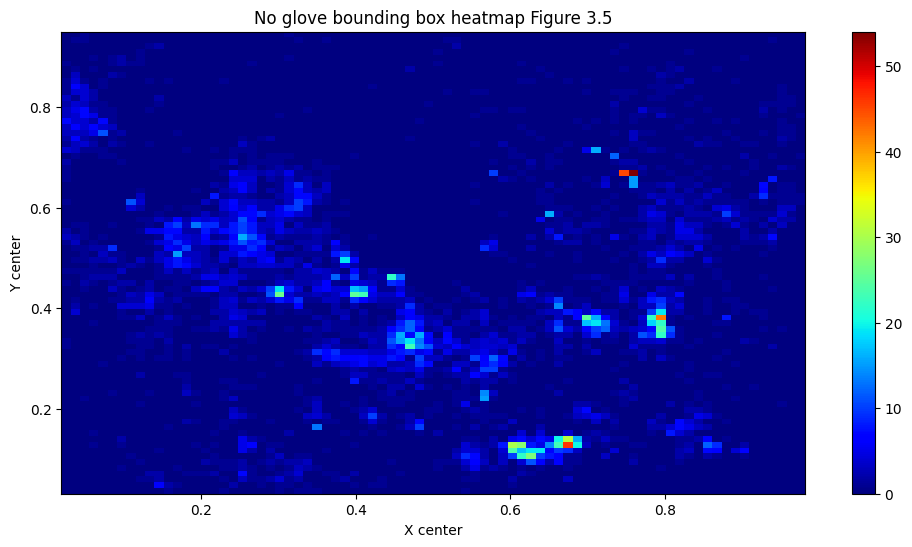

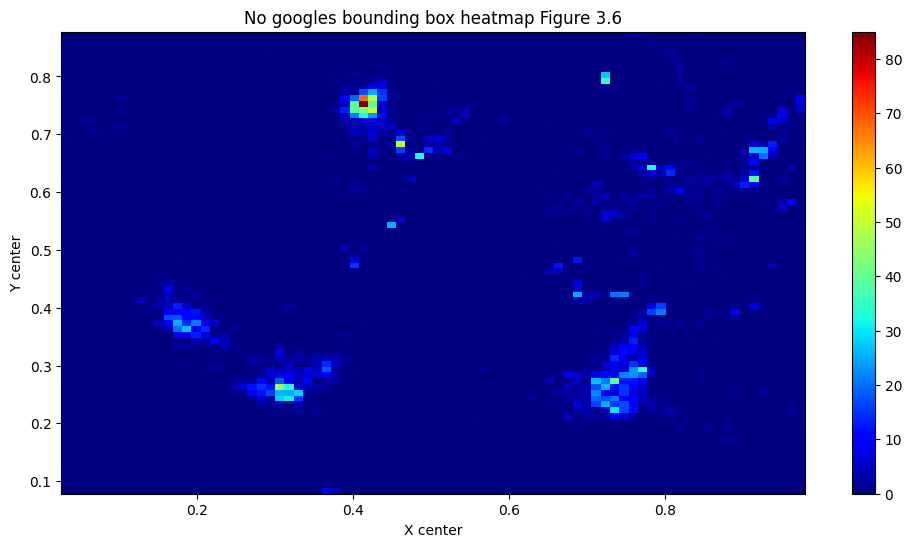

In [25]:
# Analize the properties of bounding boxes


def generate_heatmap(all_bounding_boxes_properties_without_class_index: list, title: str = "Bounding box heatmap Figure 3.2"):
    # Get the properties of the bounding boxes
    
    x_centers = [x_center for x_center, y_center, width, height in all_bounding_boxes_properties_without_class_index]
    y_centers = [y_center for x_center, y_center, width, height in all_bounding_boxes_properties_without_class_index]
    
    # Plot the heatmaps
    plt.figure(figsize=(12, 6))
    plt.hist2d(x_centers, y_centers, bins=80, cmap=plt.cm.jet)
    plt.gca().set_facecolor('xkcd:grey')
    plt.title(title)
    plt.xlabel("X center")
    plt.ylabel("Y center")
    plt.colorbar()
    plt.show()

# Generate the heatmap
generate_heatmap(all_bounding_boxes_properties_without_class_index)
generate_heatmap(glove_boundig_boxes_properties, "Glove bounding box heatmap Figure 3.3")
generate_heatmap(no_glove_boundig_boxes_properties, "No glove bounding box heatmap Figure 3.4")
generate_heatmap(googles_boundig_boxes_properties, "Googles bounding box heatmap Figure 3.5")
generate_heatmap(no_googles_boundig_boxes_properties, "No googles bounding box heatmap Figure 3.6")


### Bounding boxes surface area

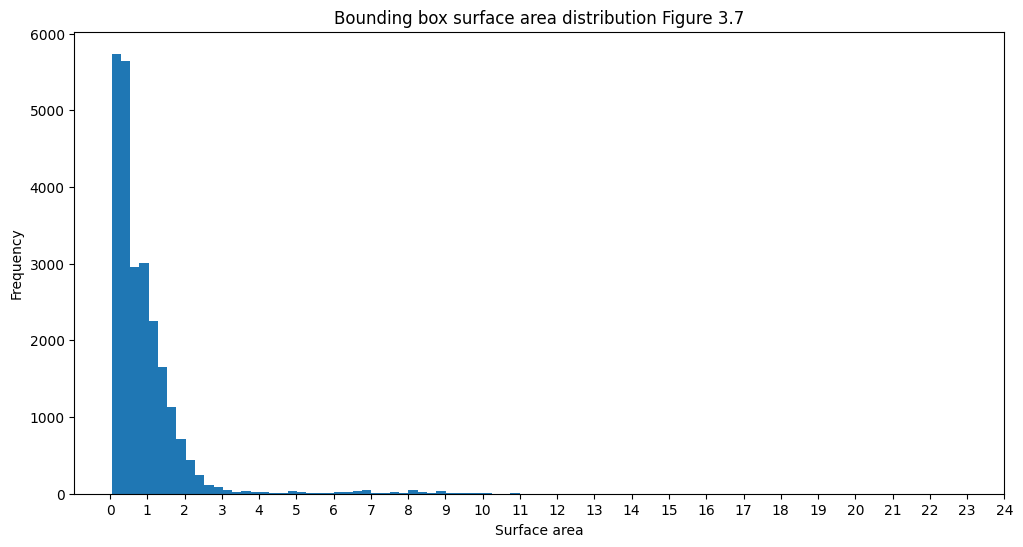

In [50]:
# Analize the surface area of bounding boxes

def generate_histogram(data: list, title: str, x_label: str, y_label: str, min : float = 0, max : float = 12, step : float = 1):
    plt.figure(figsize=(12, 6))
    plt.hist(data, bins=80)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.xticks(np.arange(min, max, step))
    plt.show()

def get_surface_area(data: list) -> list:
    surface_areas = []
    # Calculate the surface area
    for x_center, y_center, width, height in data:
        surface_areas.append(width * height*100)
    return surface_areas

generate_histogram(get_surface_area(all_bounding_boxes_properties_without_class_index), "Bounding box surface area distribution Figure 3.7", "Surface area", "Frequency", 0, 25, 1)

### Bounding boxes aspect ratio

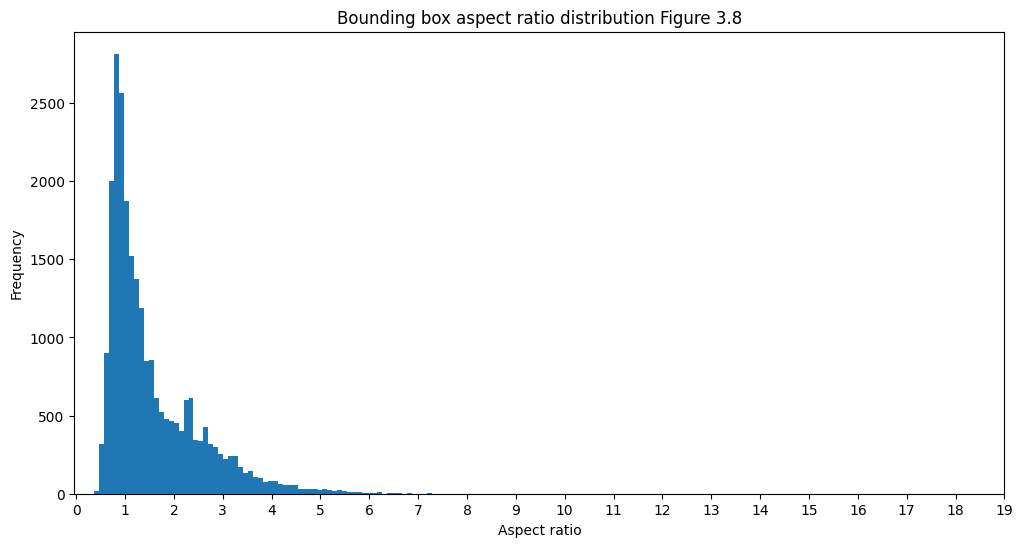

In [26]:
# Analize the aspect ratio of bounding boxes

def get_aspect_ratio(data: list) -> list:
    aspect_ratios = []
    for x_center, y_center, width, height in data:
        aspect_ratios.append(height / width)
    return aspect_ratios

generate_histogram(get_aspect_ratio(all_bounding_boxes_properties_without_class_index), "Bounding box aspect ratio distribution Figure 3.8", "Aspect ratio", "Frequency", 0, 20, 1)

## 4 Empty label files

In [49]:
# Analize the empty files

def empty_files_percentage(folder_paths: list) -> float:
    empty_files = 0
    total_files = 0
    for folder_path in folder_paths:
        for filename in os.listdir(folder_path):
            total_files += 1
            file_path = os.path.join(folder_path, filename)
            if os.stat(file_path).st_size == 0:
                empty_files += 1
    return empty_files / total_files * 100

empty_files = empty_files_percentage(all_labels_paths)

Empty files: 0


Empty files: 0.0%


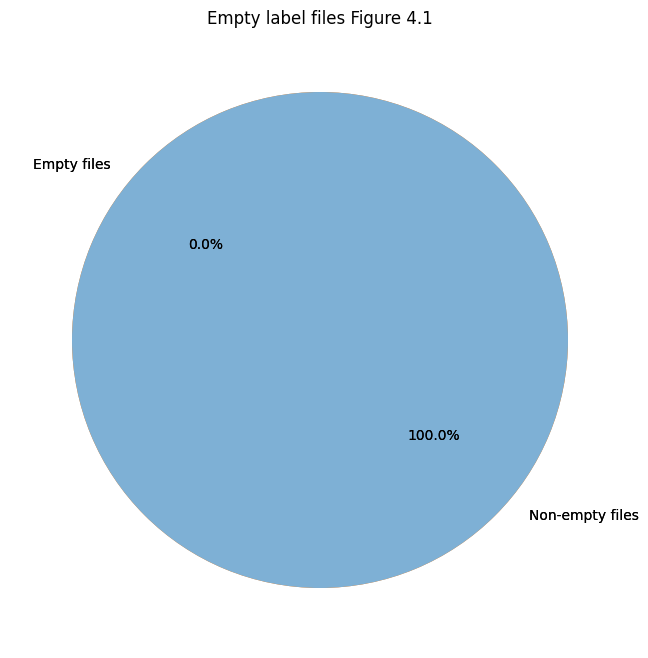

In [48]:
# Generate the pie chart

def generate_pie_chart(labels: list, sizes: list, title: str):
    plt.figure(figsize=(8, 8))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.axis('equal')
    plt.title(title)
    colors = ["#fd7f6f", "#7eb0d5"]
    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
    plt.show()



generate_pie_chart(["Empty files", "Non-empty files"], [empty_files, 100 - empty_files], "Empty label files Figure 4.1")


# Odpowiedź na historyjkę
## Krótka odpowiedź
Po dokładnej analizie wersji 4 zbioru danych, stwierdzam, że nie jest ona wystarczająco dobra, aby rozpocząć optymalny trening modelu, przynajmniej nie w aktualnym stanie.

## Omówienie wyników analizy
### 1. Analiza rozkładu klas
Dystrybucja klas jest bardzo nierównomierna, a zbiór zawiera 12 klas.

Cztery największe klasy stanowią ponad 75% wszystkich obrazów. (Załącznik 1.1)

Największa klasa stanowi około 25% wszystkich obrazów, podczas gdy najmniejsza klasa to mniej niż 1%.

Tylko 4 klasy są odpowiednie do treningu, 2 klasy są zbyt małe, a pozostałe 6 klas, czyli 50%, jest zbyt mała, aby zacząć trening. (Załącznik 1.2)

### 2. Analiza rozmiaru obrazów
Rozmiar obrazów jest zrównoważony, ponieważ ponad 80% obrazów ma rozmiar 1280x720. (Załącznik 2.1)
Jest to korzystne, szczególnie jeśli model ma być używany przez kamery przemysłowe, które często generują obrazy o tej rozdzielczości.
Trenowanie modelu na obrazach o parametrach zbliżonych do rzeczywistych jest ważne.
### 3. Analiza ramek analitycznych
Na 11978 obrazach znajduje się łącznie 24577 ramek analitycznych, co daje średnio 2.05 ramek na obraz. 

50% obrazów ma tylko 1 ramkę analityczną. (Załącznik 3.1)

W zestawie danych brak obrazów z więcej niż 11 ramkami analitycznymi, co jest zgodne z rzeczywistym zastosowaniem.

Analiza rozkładu ramek analitycznych wskazuje, że obiekty były wykrywane na całym obrazie, co jest pożądane. (Załącznik 3.2, 3.3 i 3.4)

Jednak obiekty z klas googles i no_googles nie są wykrywane na całej powierzchni obrazu, co może prowadzić do problemów w treningu modelu. (Załącznik 3.5 i 3.6)

### 4. Analiza pustych plików
W zbiorze etykiet nie ma pustych plików. (Załącznik 4.1)

## Kolejne kroki
Należy podjąć działania w celu usunięcia klas obiektów z zbyt małą ilością obrazów lub znaleźć nowe obrazy do tych klas, przy użyciu technik augmentacji obrazów,
dla najmniej reprezentowanych klas.

Konieczne jest również sprawdzenie, czy obiekty z klas googles i no_googles są wykrywane na całej powierzchni obrazu. Jeśli nie, trzeba pozyskać dodatkowe obrazy z tych klas.

## Wnioski
Zbiór danych wymaga dalszej pracy przed rozpoczęciem treningu modelu. Konieczne jest zrównoważenie dystrybucji klas, zwiększenie liczby przykładów w niektórych klasach oraz poprawa jakości detekcji obiektów na obrazach. Dopiero po tych korektach można rozpocząć optymalny trening modelu.







